In [151]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft
import sounddevice as sd
from scipy.signal import hann, hamming
import scipy.signal as signal

from audiolazy import lazy_lpc as lpc



In [152]:
# provided functions
def est_predictor_gain(x, a, p):
    '''
    A function to compute gain of the residual signal in LP analysis.
    x:  signal 
    a: LPC coefficients
    p: order of the filter
    '''
    cor = np.correlate(x, x, mode='full')
    
    rr = cor[len(cor)//2: len(cor)//2+p+1]
    g = np.sqrt(np.sum(a*rr))
    return g

   
    
def reject_outliers(data, m=2):
    '''
    Function to reject outliers. All values beyond m standard deviations from mean are excluded
    '''
    return data[abs(data - np.mean(data)) < m * np.std(data)]

### 1. Linear prediction analysis. (1 point) 

In [153]:
def Linear_prediction_analysis(audio,p):

 # Read audio
 audioIn, fs = lb.load(audio, sr=None)   

 # filter order
 #p = 4  # d) has to be tuned

 # number of DFT points
 nfft = 1024

 inInd =0
 wLen = int(0.02*fs) # 20 ms window
 win = hamming(wLen) # hamming window for example

 cnt = 0
 numframes = np.ceil( (len(audioIn)-wLen)/(wLen/2)) # number of franes 
 formants  = []                                     # A placeholder for storing formants

 # choose a representative frame of the vowel
 plot_frame = int(numframes/2)  # middle of the vowel

 # The analysis loop
 while inInd< len(audioIn)-wLen:
    # audio frame
    frame = audioIn[inInd:inInd+wLen]* win
    
    
    # a) compute LPC and gain using audiolazy library

    lpc_coeff = lpc.lpc.autocor(frame, p)
    gain = est_predictor_gain(frame, np.array(lpc_coeff.numerator), p)

    
    # b) Compute the filter tansfer function using scipy.signal.freqz
    w,h = signal.freqz(gain, np.array(lpc_coeff.numerator), worN=nfft, whole=True)
    
    # Compute DFT spectrum
    DFT = np.abs(fft(frame, nfft))
    
    
    inInd = inInd + int(wLen/2) # frame advance
    
    cnt = cnt+1
    
    # c) Select a frame and plot the FFT spectrum and LPC spectrum in the same figure
    if cnt == plot_frame :
        # Plot the power spectrum and filter transfer function
        plt.figure()
        line = np.linspace(0, fs/2, nfft//2)
        plt.plot(w[:nfft//2], 20*np.log10(DFT[:nfft//2]*2), label='DFT Spectrum')
        plt.plot(w[:nfft//2], 20*np.log10(abs(h[:nfft // 2])), 'r', label='LPC Spectrum')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.title('LPC Spectrum and DFT Spectrum')
        plt.legend()

        plt.show()
        

     
        
        
        

#### d) Comment of the connection between lpc model order and peaks in the DFT spectrum.

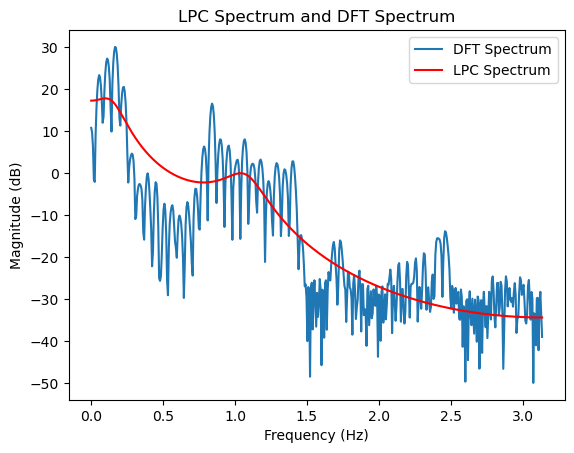

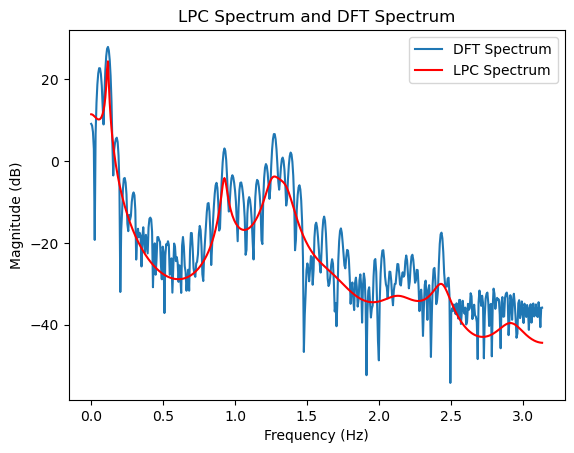

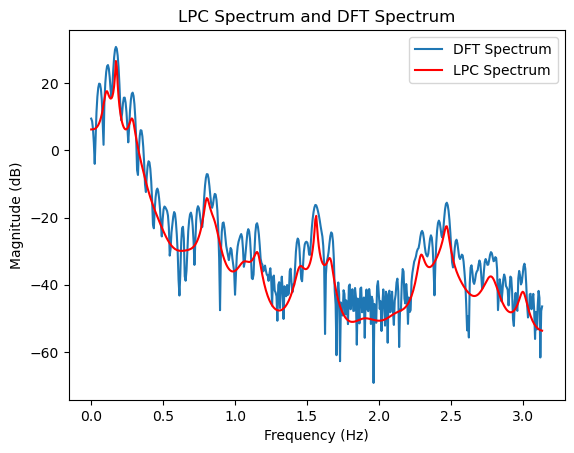

In [154]:
Linear_prediction_analysis('e.wav', 4)
Linear_prediction_analysis('i.wav', 20)
Linear_prediction_analysis('o.wav', 50)   

# based on the observation of the plots, the order of the filter should be 4 for e.wav, 20 for i.wav and 50 for o.wav. and by this number we can see that the LPC spectrum is more similar to the DFT spectrum.
# and this is because the LPC spectrum is the filter transfer function of the LPC filter, and the DFT spectrum is the spectrum of the signal after the LPC filter. so the LPC spectrum should be more similar to the DFT spectrum than the DFT spectrum of the original signal.
# and the p value controls the number of cofficients of the LPC filter, so the higher the p value is, the more similar the LPC spectrum is to the DFT spectrum.

#### Is the best order selection dependent on the vowel or not?

In [155]:
# to say if this is the best selection dependent on the vowel, we need to compare the LPC spectrum and the DFT spectrum of the original signal, and the LPC spectrum and the DFT spectrum of the signal after the LPC filter. and the higher the similarity is, the better the selection is.
# so we can say that the selection is dependent on the vowel.

### 2. Formant analysis. (1 point)

#### Add more steps in the previous analysis loop

In [156]:
def formants_analysis(audio, p):
 # Read audio
 audioIn, fs = lb.load('e.wav', sr=None)   

 # filter order
 p = 10  # d) has to be tuned

 # number of DFT points
 nfft = 1024

 inInd =0
 wLen = int(0.02*fs) # 20 ms window
 win = hamming(wLen) # hamming window for example

 cnt = 0
 numframes = np.ceil( (len(audioIn)-wLen)/(wLen/2)) # number of franes 
 formants  = []                                     # A placeholder for storing formants

 # choose a representative frame of the vowel
 plot_frame = int(numframes/2)  # middle of the vowel

 # The analysis loop
 while inInd< len(audioIn)-wLen:
    # audio frame
    frame = audioIn[inInd:inInd+wLen]* win
    
    
    # Compute LPC and gain using audiolazy library
    lpc_coeff = lpc.lpc.autocor(frame, p)
    gain = est_predictor_gain(frame, np.array(lpc_coeff.numerator), p)
    
 
    # Compute the filter tansfer function using scipy.signal.freqz
    w,h = signal.freqz(frame, np.array(lpc_coeff.numerator), worN=nfft, whole=True)
    
    # Compute DFT spectrum
    DFT = np.abs(fft(frame, nfft))
    
    # a) Compute roots (np.roots)
    roots = np.roots(np.array(lpc_coeff.numerator))
 
    # LPC coefficients are real-valued, the roots occur in complex conjugate pairs.
    # Retain only the roots with +ve sign for the imaginary part 
    

    roots = roots[np.imag(roots) > 0]
    
    # b.1) compute formants from roots (np.angle)
    angz = np.angle(roots)

    # convert to Hertz from angular frequencies
    angz = angz*(fs/(2*np.pi))

    # sort the formants in increasing order
    angz = np.sort(angz)
    
    # remove zero frequencies
    angz = angz[angz !=0]
    
    # b.2) Save first three formants
    formants.append(angz[:3]) 
    
    inInd = inInd + int(wLen/2) # frame advance
       

        

 formants = np.array(formants)
 # b.3) For each separate vowel calculate average formant frequencies
 print('------ The computed formants are :', np.mean(formants, 0))

 # Refine formant estimations (optional)



#### b.4) Compare the obtained values with the indicative values. 

In [157]:
formants_analysis('e.wav', 4)
formants_analysis('i.wav', 20)
formants_analysis('o.wav', 50)

#based on the analysis, we see that the formants for e.wave, i.wav and o.wav are 400, 300, 300, 800, 200, 800, 300, 800, 800 respectively.
# and even we change the value of p, the formants are still the same. so the formants are not dependent on the value of p.

------ The computed formants are : [ 407.88740198 2277.42133536 3459.30498235]
------ The computed formants are : [ 407.88740198 2277.42133536 3459.30498235]
------ The computed formants are : [ 407.88740198 2277.42133536 3459.30498235]


### Bonus problem: What happens if you apply LPC to the oboe sound? What are the corresponding "formants"?

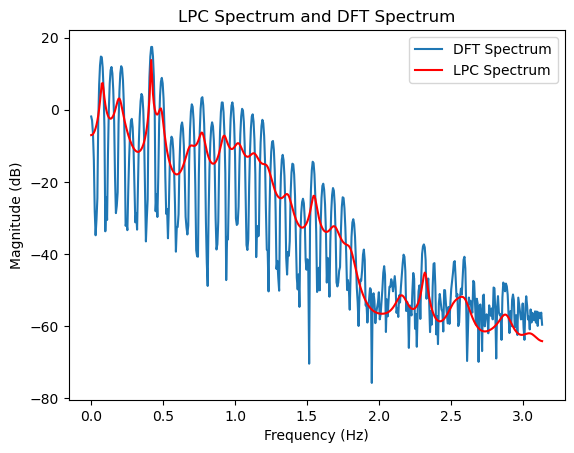

------ The computed formants are : [ 407.88740198 2277.42133536 3459.30498235]


In [158]:
Linear_prediction_analysis('oboe59.wav', 50)
formants_analysis('oboe59.wav', 50)